# Denoising Example

## Setup

In [16]:
# Load packages
import MIRT: jim
using Flux
using Random: seed!
using Images, TestImages
using Noise
using Plots
using PyCall
np = pyimport("numpy")
cv = pyimport_conda("cv2", "opencv")
# We will want to suppress some output stuff for neatness
using Suppressor 
# BM3D is not a registered package!
using BM3D

# Load external files
@suppress include("dncnn.jl") # Suppress weight printing

# Create a single Julia function for nlmeans
function nlMeans(img::Array{Gray{T},2}, h::Number = 3) where T
    pyimg = np.uint8(reinterpret(UInt8, img)) # Convert julia image to np.uint8 array
    img_denoised = cv.fastNlMeansDenoising(pyimg, h=h)
end

# Create a jim interface
function jim(img::Array{Gray{T},2}, title::AbstractString; kwargs...) where T
    tmp = reinterpret(N0f8, img')
    jim(tmp, title; kwargs...)
end

function jim(img::Array{Gray{T},2}; kwargs...) where T
    tmp = reinterpret(N0f8, img')
    jim(tmp; kwargs...)
end;

In [2]:
# using Pkg
# Pkg.add("Flux")
# Pkg.add(url = "https://github.com/Longhao-Chen/BM3D.jl.git")
# Pkg.add("PyCall")
# Pkg.add("Suppressor")
# Pkg.add("TestImages")
# Pkg.add("Noise")
# Pkg.add("JSON")
# Pkg.add("ImageCore")

## Generate the noisy test image

In [17]:
img = testimage("cameraman.tif") # Load the test image
(nx, ny) = size(img) # Determine the size of the test image
σNoise = 0.2 # Noise std. dev.
μNoise = 0.0 # Noise mean
# Using additive gaussian noise
seed!(1)
noisyImg  = add_gauss(img, σNoise, μNoise, clip=true)
noisyPSNR = assess_psnr(noisyImg, img); # PSNR

noisyPSNR = 14.7355175f0


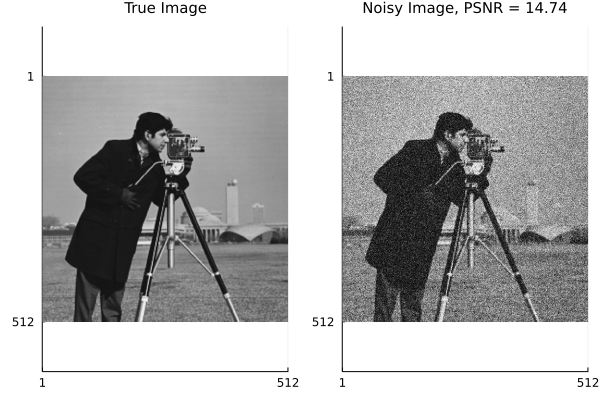

In [52]:
@show noisyPSNR;
# Do some plotting
pTrue  = jim(     img, "True Image")
pNoisy = jim(noisyImg, "Noisy Image, PSNR = $(round(noisyPSNR, digits = 2))")
plot(pTrue, pNoisy, colorbar = false, titlefontsize=10)

In [19]:
savefig("rawPlusNoise.pdf")

## Do some denoising

In [20]:
# Using the DNCNN
cnnIm   = dncnn_denoise(noisyImg) |> (x) -> x/max(x...)
cnnIm   = convert(Array{Gray{N0f8}, 2}, cnnIm)
cnnPSNR = assess_psnr(cnnIm, img);
@show cnnPSNR;

┌ Warning: Slow fallback implementation invoked for conv!  You probably don't want this; check your datatypes.
│   yT = Float32
│   T1 = Gray{N0f8}
│   T2 = Float32
└ @ NNlib /home/april/.julia/packages/NNlib/xpcWJ/src/conv.jl:206


cnnPSNR = 24.019556f0


In [21]:
# Using BM3D
bm3dIm   = @suppress bm3d(noisyImg, σNoise) |> (x) -> max.(x/max(x...), 0)
bm3dIm   = convert(Array{Gray{N0f8}, 2}, bm3dIm)
bm3dPSNR = assess_psnr(bm3dIm, img);
@show bm3dPSNR;

bm3dPSNR = 25.845257f0


In [22]:
# Using NLMeans via Python
nlMeansIm   = nlMeans(noisyImg, σNoise*255.0) |> (x) -> x/max(x...)
nlMeansIm   = convert(Array{Gray{N0f8}, 2}, nlMeansIm)
nlMeansPSNR = assess_psnr(nlMeansIm, img);
@show nlMeansPSNR;

nlMeansPSNR = 21.674774f0


In [66]:
using Images: imROF
tvIm = imROF(convert(Array{Gray{Float32}, 2}, noisyImg), 0.45, 5) |> (x) -> max.(x/max(x...), 0)
# jim(tvMeansIm)
tvIm   = convert(Array{Gray{N0f8}, 2}, tvIm)
tvPSNR = assess_psnr(tvIm, img);
@show tvPSNR;

tvPSNR = 23.818844f0


In [67]:
pTv = jim(tvIm, "TV, PSNR = $(round(tvPSNR, digits = 2))")
blank = plot([], axis=([], false), legend=false);
pCNN  = jim( cnnIm, "DNCNN, PSNR = $(round(cnnPSNR, digits = 2))")
pBM3D = jim(bm3dIm, "BM3D, PSNR = $(round(bm3dPSNR, digits = 2))")
pNlMeans = jim(nlMeansIm, "NLMeans, PSNR = $(round(nlMeansPSNR, digits = 2))")
plot(pNoisy, pTv, blank, pCNN, pBM3D, pNlMeans, layout = (2,3), size=(900, 600), colorbar = false, titlefontsize=10)

In [68]:
savefig("denoisingGrid.pdf")

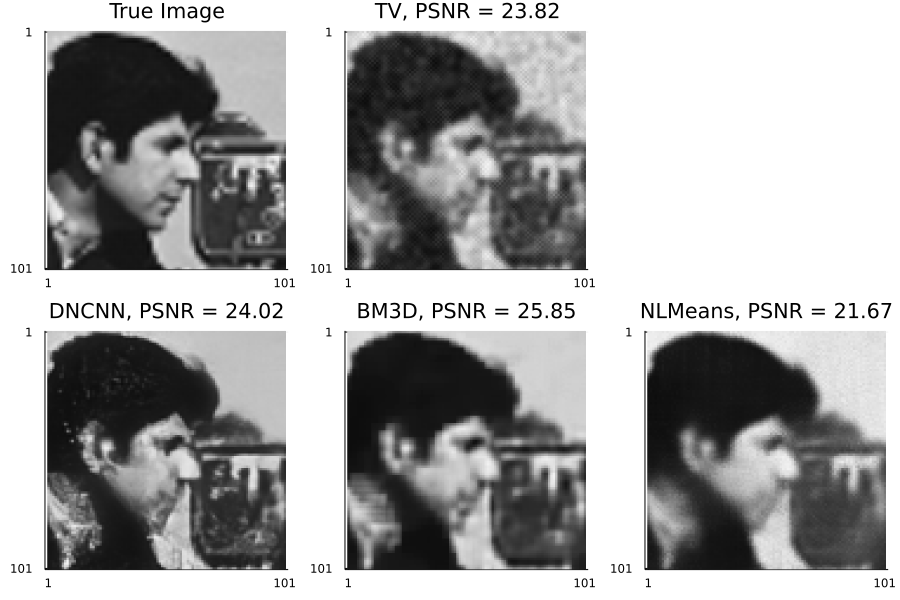

In [69]:
faceIdx = (75:175, 200:300)
pfTrue  = jim(     img[faceIdx...], "True Image")
pfTv  = jim(     tvIm[faceIdx...], "TV, PSNR = $(round(tvPSNR, digits = 2))")
blank = plot([], axis=([], false), legend=false);
pfCNN  = jim( cnnIm[faceIdx...], "DNCNN, PSNR = $(round(cnnPSNR, digits = 2))")
pfBM3D = jim(bm3dIm[faceIdx...], "BM3D, PSNR = $(round(bm3dPSNR, digits = 2))")
pfNlMeans = jim(nlMeansIm[faceIdx...], "NLMeans, PSNR = $(round(nlMeansPSNR, digits = 2))")
plot(pfTrue, pfTv, blank, pfCNN, pfBM3D, pfNlMeans, layout = (2,3), size=(900, 600), colorbar = false)

In [70]:
savefig("denoisingFaces.pdf")